In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=20.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2
 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 10e-6

d1 = 0.
d2 = 15.5e-6
d3 = 15.5e-6
d4 = 0.

# Get crystal angles
eta_b1 = np.zeros(8, dtype=np.float64)
theta_b1 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg + d2,
                     3 * np.pi / 2. + bragg + d2,
                     np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. - bragg + d4,
                     np.pi / 2. - bragg + d4])

rho_b1 = theta_b1 + np.pi

asy_angle = np.deg2rad(5)
rho_b1[1] += asy_angle
rho_b1[2] -= asy_angle
rho_b1[5] -= asy_angle
rho_b1[6] += asy_angle

tau_b1 = np.zeros(8)


# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=8,
                                           hlen=np.array([h_length, ] * 8),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6 - 1e5, 1.1e5, 6.5e5, 1.15e5, 6e6, 1e6]
path_list_var = [5e6, 1e4, 5e4, 1e4, 20e4, 10e4, 10e4, 10.5e4, 6e6, 1e6]
delay_time = 80

# Arrange the crystals

In [3]:
# ---------------------------------------------------------------------------
#                  Initialize the position of the crystals
# ---------------------------------------------------------------------------
(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

In [4]:
total_path = np.sum(fix_branch_path)
print(total_path/1e6)

11.232925757182603


# Rotate and shift the crystals to get the spatial instability

In [5]:
# In this simulation, I would like to study the derivation across 10 urad variation.
# The num is the number of partitions I divide the 10 urad into.
num = 100
num_total = 2 * num + 1

kout_holder = np.zeros((3, num_total, 3), dtype=np.float64)
position_holder = np.zeros((3, num_total, 3), dtype=np.float64)

for a_idx in range(3):  # The axis index

    eular_list = np.zeros((num_total, 3), dtype = np.float64)
    eular_list[:, a_idx] = np.arange(-num, num + 1) * 1e-5 / num

    for idx in range(num_total):

        
        ##############################################################################################
        #                 Step 1: Initialize the crystals
        ##############################################################################################
        crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                                      hlen=np.array([h_length, ] * 8),
                                                      theta=theta_b1,
                                                      eta=eta_b1,
                                                      rho=rho_b1,
                                                      tau=tau_b1,
                                                      surface_points=np.copy(intersect_var[1:-2]))
        
        total_path = np.sum(fix_branch_path)
        ##############################################################################################
        #                 Step 2: Rotate the crystals
        ##############################################################################################
        # Define rotation matrix
        rot_mat = Rotation.from_euler('xyz', eular_list[idx], degrees=False)
        matrix = rot_mat.as_dcm()

        crystal.rotate_shift_crystal_list(crystal_list=crystal_list_1[4:],
                                          rot_mat=matrix,
                                          displacement=None)
        
        ##############################################################################################
        #                 Step 3: Calculate the kout and intersection points
        ##############################################################################################
        crystal_list = list(range(10))
        crystal_list[0] = grating_list[0]
        crystal_list[1:-1] = crystal_list_1[:]
        crystal_list[-1] = grating_list[1]
        
        (intersects, 
        kouts) = lightpath.get_light_trajectory_with_total_path(kin_vec=my_pulse.k0,
                                                                init_point=np.zeros(3, dtype=np.float64),
                                                                total_path=total_path,
                                                                crystal_list=crystal_list,
                                                                g_orders = [1, -1])
        
        # Save the information
        kout_holder[:, idx, a_idx] = kouts[-1]
        position_holder[:,idx,a_idx] = intersects[-2]

In [6]:
for x in crystal_list:
    print(x.normal)

[0. 0. 1.]
[0.         0.94654018 0.32258595]
[ 0.         -0.97105352 -0.238862  ]
[ 0.         -0.97090632  0.23945963]
[ 0.          0.94634145 -0.32316848]
[ 9.46341447e-06 -9.46341447e-01  3.23168480e-01]
[-9.70906321e-06  9.70906321e-01 -2.39459635e-01]
[-9.71053524e-06  9.71053524e-01  2.38861997e-01]
[ 9.46540177e-06 -9.46540177e-01 -3.22585946e-01]
[0. 0. 1.]


In [7]:
kouts.shape

(11, 3)

# Calculate gradient

In [8]:
kout_diff = kout_holder - kout_var[-1][:, np.newaxis, np.newaxis]

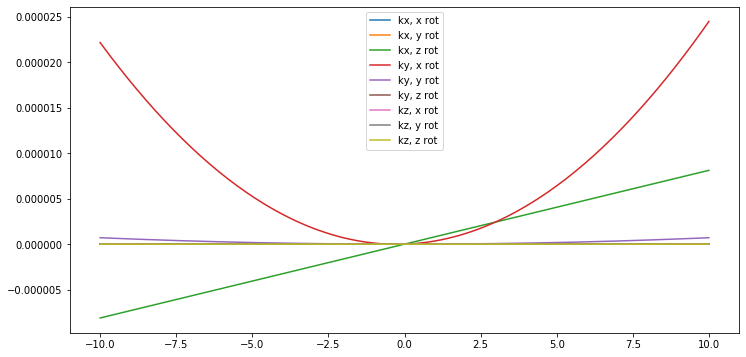

In [9]:
axis = ['x', 'y', 'z']
momen = ['kx', 'ky', 'kz']

plt.figure(figsize=(12,6))

for x in range(3):
    for y in range(3):
        plt.plot(np.arange(-100, 101) / 10., kout_diff[x, :, y], label="{}, {} rot".format(momen[x],
                                                                                           axis[y]))
        
plt.legend()
plt.show()

In [19]:
gradient_holder = np.zeros((3, 3))

angles = np.arange(-100, 101) / 10.  # urad

for x in range(3):
    for y in range(3):
        
        # Slope through the origin
        slope_o = np.dot(angles, kout_diff[x, :, y]) / np.dot(angles, angles)
        
        # Save the gradient
        gradient_holder[x, y] = slope_o

In [20]:
for x in range(3):
    for y in range(3):
        print(x,y)
        print(gradient_holder[x,y])

0 0
0.0
0 1
2.496916725548084e-10
0 2
8.10691444749058e-07
1 0
1.158785239855803e-07
1 1
6.884411422932838e-25
1 2
-3.0559354682762954e-29
2 0
-3.483976234448078e-11
2 1
-1.2223741873105181e-28
2 2
-7.639838670690738e-30


In [21]:
print(gradient_holder)

[[ 0.00000000e+00  2.49691673e-10  8.10691445e-07]
 [ 1.15878524e-07  6.88441142e-25 -3.05593547e-29]
 [-3.48397623e-11 -1.22237419e-28 -7.63983867e-30]]


In [12]:
print(np.arctan(gradient_holder * 10 / my_pulse.klen0))

[[ 0.00000000e+00  4.92709034e-14  1.59971294e-10]
 [ 2.28659590e-11  1.35848011e-28 -6.03018513e-33]
 [-6.87482505e-15 -2.41207405e-32 -1.50754628e-33]]


In [ ]:
my_pulse.klen0

# Calculate spatial gradient

In [13]:
position_diff = position_holder - intersect_var[-2][:, np.newaxis, np.newaxis]

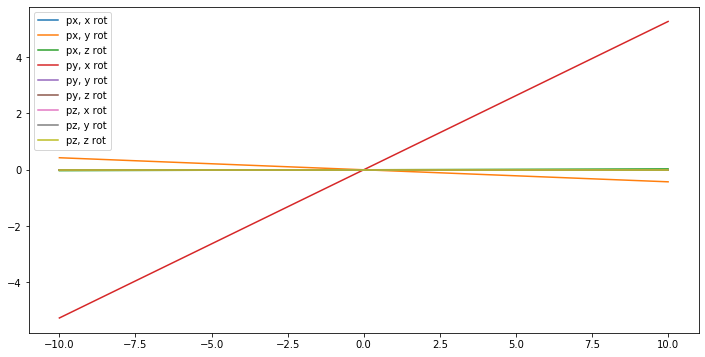

In [14]:
axis = ['x', 'y', 'z']
pos = ['px', 'py', 'pz']

plt.figure(figsize=(12,6))

for x in range(3):
    for y in range(3):
        plt.plot(np.arange(-100, 101) / 10., position_diff[x, :, y], label="{}, {} rot".format(pos[x],
                                                                                           axis[y]))
        
plt.legend()
plt.show()

In [15]:
gradient_holder = np.zeros((3, 3))

angles = np.arange(-100, 101) / 10.  # urad

for x in range(3):
    for y in range(3):
        
        # Slope through the origin
        slope_o = np.dot(angles, position_diff[x, :, y]) / np.dot(angles, angles)
        
        # Save the gradient
        gradient_holder[x, y] = slope_o

In [16]:
print(gradient_holder)

[[ 0.00000000e+00 -4.27642093e-02  3.15175349e-03]
 [ 5.26699814e-01  2.40328544e-23 -4.38098909e-25]
 [ 1.12153321e-22  1.12153321e-22  1.12153321e-22]]


In [17]:
print(np.arctan(gradient_holder * 10 ))

[[ 0.00000000e+00 -4.04106394e-01  3.15071051e-02]
 [ 1.38316809e+00  2.40328544e-22 -4.38098909e-24]
 [ 1.12153321e-21  1.12153321e-21  1.12153321e-21]]
